### (1) !pip install

In [ ]:
#한글 깨짐
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,397 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
# 설치해야 할 것들, 설치 후 런타임 다시 시작 필요
!pip install scikit-learn==0.23.2
!pip install h5py
!pip install typing-extensions
!pip install wheel
!pip install catboost
!pip install xgboost
!pip install folium
!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import random as rn
import os
import warnings
import scipy.stats as stats
import folium
import geopy.distance
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from collections import Counter

plt.rc('font',  family='NanumBarunGothic')
plt.rcParams["axes.unicode_minus"]=False #마이너스 깨짐 해결
%matplotlib inline
warnings.filterwarnings(action='ignore')

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
import jinja2
from pycaret.regression import *

### (2) 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# train(9월): 모델 학습 및 테스트용
# test(10월): 실 데이터 예측용
train=pd.read_csv("/content/drive/MyDrive/Project/팀 프로젝트/2_jeju_bus/data/train.csv", index_col = 0)
test=pd.read_csv("/content/drive/MyDrive/Project/팀 프로젝트/2_jeju_bus/data/test.csv", index_col = 0)

# 제주 주소 데이터
bus_code= pd.read_csv("/content/drive/MyDrive/Project/팀 프로젝트/2_jeju_bus/data/data_re/bus_code_amend.csv", index_col = 0)

In [ ]:
train.head()

date  bus_route_id in_out  station_code  station_name  latitude  \
id                                                                          
0   2019-09-01       4270000     시외           344         제주썬호텔  33.48990   
1   2019-09-01       4270000     시외           357          한라병원  33.48944   
2   2019-09-01       4270000     시외           432          정존마을  33.48181   
3   2019-09-01       4270000     시내          1579  제주국제공항(600번)  33.50577   
4   2019-09-01       4270000     시내          1646      중문관광단지입구  33.25579   

    longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  10~11_ride  \
id                                                                   
0   126.49373       0.0       1.0       2.0        5.0         2.0   
1   126.48508       1.0       4.0       4.0        2.0         5.0   
2   126.47352       1.0       1.0       0.0        2.0         0.0   
3   126.49252       0.0      17.0       6.0       26.0        14.0   
4   126.41260       0.0       0.0       0.0        0.0         0.0   

    11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  \
id                                                                    
0          6.0          0.0          0.0          0.0           0.0   
1          6.0          0.0          0.0          0.0           0.0   
2          0.0          0.0          0.0          0.0           0.0   
3         16.0          0.0          0.0          0.0           0.0   
4          0.0          0.0          0.0          0.0           1.0   

    10~11_takeoff  11~12_takeoff  18~20_ride  
id                                            
0             0.0            0.0         0.0  
1             0.0            0.0         5.0  
2             0.0            0.0         2.0  
3             0.0            0.0        53.0  
4             0.0            0.0         0.0

In [ ]:
test.head()

date  bus_route_id in_out  station_code  station_name  latitude  \
id                                                                              
415423  2019-10-01       4270000     시외           344         제주썬호텔  33.48990   
415424  2019-10-01       4270000     시외           357          한라병원  33.48944   
415425  2019-10-01       4270000     시외           432          정존마을  33.48181   
415426  2019-10-01       4270000     시내          1579  제주국제공항(600번)  33.50577   
415427  2019-10-01       4270000     시내          1636          롯데호텔  33.24872   

        longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  10~11_ride  \
id                                                                       
415423  126.49373       4.0       4.0       7.0        2.0         9.0   
415424  126.48508       1.0       6.0       6.0        1.0         8.0   
415425  126.47352       2.0       4.0       2.0        2.0         2.0   
415426  126.49252       1.0      11.0      18.0        8.0        26.0   
415427  126.41032       0.0       0.0       0.0        0.0         0.0   

        11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  \
id                                                                        
415423         1.0          0.0          0.0          0.0           0.0   
415424        11.0          0.0          0.0          0.0           0.0   
415425         1.0          0.0          0.0          0.0           0.0   
415426        20.0          0.0          0.0          0.0           0.0   
415427         0.0          0.0          0.0          0.0           1.0   

        10~11_takeoff  11~12_takeoff  
id                                    
415423            0.0            1.0  
415424            0.0            0.0  
415425            0.0            0.0  
415426            0.0            0.0  
415427            0.0            0.0

In [ ]:
bus_code.head()

station_code  latitude  longitude                       address    si  \
0           344  33.48990  126.49373               대한민국 제주시 제주 썬호텔   제주시   
1           357  33.48944  126.48508          대한민국 제주특별자치도 제주시 도령로   제주시   
2           432  33.48181  126.47352                 대한민국 제주시 정존마을   제주시   
3          1579  33.50577  126.49252  대한민국 제주특별자치도 제주시 용담2동 1984-5   제주시   
4          1646  33.25579  126.41260            대한민국 서귀포시 중문관광단지입구  서귀포시   

   si_class  si_jeju  si_seogwipo  
0         1        1            0  
1         1        1            0  
2         1        1            0  
3         1        1            0  
4         0        0            1

### (3) 필요한 항목 추가(전처리)

#### 1) 비 항목 추가
- 비 오면 1, 그렇지 않으면 0

In [ ]:
IsRainy = ['09-04', '09-05', '09-06', '09-07', '09-10', '09-11', '09-12', '09-13', '09-14', '09-22', 
            '10-02', '10-03', '10-05', '10-07']
IsRainy = ['2019-'+ day for day in IsRainy]

train['Rain'] = train.apply(lambda row: 1 if row.date in IsRainy else 0, axis=1)
test['Rain'] = test.apply(lambda row: 1 if row.date in IsRainy else 0, axis=1)

train.shape, test.shape

((415423, 21), (228170, 20))

#### 2) 태풍 항목 추가
- 태풍이 제주도에 영향 미치날이면 1, 아니면 0

In [ ]:
train['typhoon'] = train['date'].apply(lambda date : 1 if date in ('2019-09-06', '2019-09-07', '2019-09-20', '2019-09-21', '2019-09-22', '2019-10-01','2019-10-02') else 0)
test['typhoon'] = test['date'].apply(lambda date : 1 if date in ('2019-09-06', '2019-09-07', '2019-09-20', '2019-09-21', '2019-09-22', '2019-10-01','2019-10-02') else 0)

train.shape, test.shape

((415423, 22), (228170, 21))

#### 3) 시내/시외 항목 변경
- 시내:0, 시외:1 로 각각 변환

In [ ]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

#### 4) 평일, 주말, 공휴일 항목 추가

In [ ]:
# 공휴일 확인
holidays = ['09-12', '09-13', '09-14', '10-03', '10-09']
holidays = ['2019-'+day for day in holidays]

train['holiday'] = train.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
test['holiday'] = test.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
train.shape, test.shape

((415423, 23), (228170, 22))

In [ ]:
#date 변수 변환
train['date2'] = pd.to_datetime(train['date'])
test['date2']=pd.to_datetime(test['date'])
train['week'] = train['date2'].dt.weekday #요일별로 변수 변경(train)

test['date2'] = pd.to_datetime(test['date'])
test['week'] = test['date2'].dt.weekday #요일별로 변수 변경(test)

del train['date2'] #임의 컬럼 삭제
del test['date2']

In [ ]:
# week(평일), weekend(주말), holiday(공휴일)
holidays = ['09-12', '09-13', '09-14', '10-03', '10-09']
holidays = ['2019-'+day for day in holidays]

train['holiday'] = train.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
train['weekend'] = train.apply(lambda row: 1 if row.week in [5,6] else 0, axis=1)
train['Mon'] = train.apply(lambda row: 1 if row.week == 0 else 0, axis=1)
train['Tue'] = train.apply(lambda row: 1 if row.week == 1 else 0, axis=1)
train['Wed'] = train.apply(lambda row: 1 if row.week == 2 else 0, axis=1)
train['Thu'] = train.apply(lambda row: 1 if row.week == 3 else 0, axis=1)
train['Fri'] = train.apply(lambda row: 1 if row.week == 4 else 0, axis=1)

test['holiday'] = test.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
test['weekend'] = test.apply(lambda row: 1 if row.week in [5,6] else 0, axis=1)
test['Mon'] = test.apply(lambda row: 1 if row.week == 0 else 0, axis=1)
test['Tue'] = test.apply(lambda row: 1 if row.week == 1 else 0, axis=1)
test['Wed'] = test.apply(lambda row: 1 if row.week == 2 else 0, axis=1)
test['Thu'] = test.apply(lambda row: 1 if row.week == 3 else 0, axis=1)
test['Fri'] = test.apply(lambda row: 1 if row.week == 4 else 0, axis=1)

#### 4) 제주시 서귀포시 항목 추가
- si_class : 제주시면 1, 세귀포시는 0
- si_jeju : 제주시면 1, 그렇지 않으면 0
- si_seogwipo : 서귀포시면 1, 그렇지 않으면 0

In [ ]:
bus_code.head()

station_code  si_class  si_jeju  si_seogwipo
0           344         1        1            0
1           357         1        1            0
2           432         1        1            0
3          1579         1        1            0
4          1646         0        0            1

In [ ]:
# si_jeju : 제주시면 1, 그렇지 않으면 0
# si_seogwipo : 서귀포시면 1, 그렇지 않으면 0
bus_code=bus_code[['station_code', 'si_class', 'si_jeju', 'si_seogwipo']]
train=pd.merge(train, bus_code, how='left', on='station_code')
test=pd.merge(test, bus_code, how='left', on='station_code')

In [ ]:
train.head()

date  bus_route_id  in_out  station_code  station_name  latitude  \
0  2019-09-01       4270000       1           344         제주썬호텔  33.48990   
1  2019-09-01       4270000       1           357          한라병원  33.48944   
2  2019-09-01       4270000       1           432          정존마을  33.48181   
3  2019-09-01       4270000       0          1579  제주국제공항(600번)  33.50577   
4  2019-09-01       4270000       0          1646      중문관광단지입구  33.25579   

   longitude  6~7_ride  7~8_ride  8~9_ride  ...  week  weekend  Mon  Tue  Wed  \
0  126.49373       0.0       1.0       2.0  ...     6        1    0    0    0   
1  126.48508       1.0       4.0       4.0  ...     6        1    0    0    0   
2  126.47352       1.0       1.0       0.0  ...     6        1    0    0    0   
3  126.49252       0.0      17.0       6.0  ...     6        1    0    0    0   
4  126.41260       0.0       0.0       0.0  ...     6        1    0    0    0   

   Thu  Fri  si_class  si_jeju  si_seogwipo  
0    0    0         1        1            0  
1    0    0         1        1            0  
2    0    0         1        1            0  
3    0    0         1        1            0  
4    0    0         0        0            1  

[5 rows x 33 columns]

#### 5) 측정소별 거리 측정

In [ ]:
jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

In [ ]:
import geopy.distance 

In [ ]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name'])

Counter({0: 1479, 3: 828, 1: 659, 2: 597})

In [ ]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

#### 6) 시간 2시간 씩 합치기

In [ ]:
train['68a']=train['6~7_ride']+train['7~8_ride']
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

#### 7) 최종 데이터 저장

In [ ]:
train.head()

date  bus_route_id  in_out  station_code  station_name  latitude  \
0  2019-09-01       4270000       1           344         제주썬호텔  33.48990   
1  2019-09-01       4270000       1           357          한라병원  33.48944   
2  2019-09-01       4270000       1           432          정존마을  33.48181   
3  2019-09-01       4270000       0          1579  제주국제공항(600번)  33.50577   
4  2019-09-01       4270000       0          1646      중문관광단지입구  33.25579   

   longitude  6~7_ride  7~8_ride  8~9_ride  ...  si_jeju  si_seogwipo  \
0  126.49373       0.0       1.0       2.0  ...        1            0   
1  126.48508       1.0       4.0       4.0  ...        1            0   
2  126.47352       1.0       1.0       0.0  ...        1            0   
3  126.49252       0.0      17.0       6.0  ...        1            0   
4  126.41260       0.0       0.0       0.0  ...        0            1   

    dis_jeju  dis_gosan  dis_seongsan     dis_po  dist_name   68a  810a  1012a  
0   4.286659  37.692766     37.713630  27.841879          0   1.0   7.0    8.0  
1   4.966848  37.008492     38.465822  27.996179          0   5.0   6.0   11.0  
2   6.330746  35.642126     39.259820  27.496551          0   2.0   2.0    0.0  
3   3.575272  38.643401     38.386802  29.579404          0  17.0  32.0   30.0  
4  30.652098  23.648361     45.899140  14.269792          3   0.0   0.0    0.0  

[5 rows x 41 columns]

In [ ]:
test.head()

date  bus_route_id  in_out  station_code  station_name  latitude  \
0  2019-10-01       4270000       1           344         제주썬호텔  33.48990   
1  2019-10-01       4270000       1           357          한라병원  33.48944   
2  2019-10-01       4270000       1           432          정존마을  33.48181   
3  2019-10-01       4270000       0          1579  제주국제공항(600번)  33.50577   
4  2019-10-01       4270000       0          1636          롯데호텔  33.24872   

   longitude  6~7_ride  7~8_ride  8~9_ride  ...  si_jeju  si_seogwipo  \
0  126.49373       4.0       4.0       7.0  ...        1            0   
1  126.48508       1.0       6.0       6.0  ...        1            0   
2  126.47352       2.0       4.0       2.0  ...        1            0   
3  126.49252       1.0      11.0      18.0  ...        1            0   
4  126.41032       0.0       0.0       0.0  ...        0            1   

    dis_jeju  dis_gosan  dis_seongsan     dis_po  dist_name   68a  810a  1012a  
0   4.286659  37.692766     37.713630  27.841879          0   8.0   9.0   10.0  
1   4.966848  37.008492     38.465822  27.996179          0   7.0   7.0   19.0  
2   6.330746  35.642126     39.259820  27.496551          0   6.0   4.0    3.0  
3   3.575272  38.643401     38.386802  29.579404          0  12.0  26.0   46.0  
4  31.460686  23.594010     46.355301  14.445605          3   0.0   0.0    0.0  

[5 rows x 40 columns]

In [ ]:
train.to_csv("/content/drive/MyDrive/Project/팀 프로젝트/2_jeju_bus/data/train_final.csv",sep=",", encoding='utf-8')
test.to_csv("/content/drive/MyDrive/Project/팀 프로젝트/2_jeju_bus/data/test_final.csv", sep=",", encoding='utf-8')

### (4) EDA

In [ ]:
train=pd.read_csv("/content/drive/MyDrive/Project/팀 프로젝트/2_jeju_bus/data/train_final.csv", index_col = 0)
test=pd.read_csv("/content/drive/MyDrive/Project/팀 프로젝트/2_jeju_bus/data/test_final.csv", index_col = 0)

#### 1) 시 구분에 따른 인원 비교 그래프


In [ ]:
df_date_si = train.groupby(['date', 'si_class']).sum()['18~20_ride'].reset_index()
df_date_si.columns = ['date', 'si_class', 'count']
df_date_si.head()

date  si_class    count
0  2019-09-01         0   2322.0
1  2019-09-01         1   9215.0
2  2019-09-02         0   3459.0
3  2019-09-02         1  17102.0
4  2019-09-03         0   3550.0

In [ ]:
df_date_si = train.groupby(['date', 'si_class']).sum()['18~20_ride'].reset_index()
df_date_si.columns = ['date', '시 구분', 'count']
df_date_si['시 구분'] = df_date_si['시 구분'].map({1:'제주시', 0:'서귀포시'})
df_date_si.head()

date  시 구분    count
0  2019-09-01  서귀포시   2322.0
1  2019-09-01   제주시   9215.0
2  2019-09-02  서귀포시   3459.0
3  2019-09-02   제주시  17102.0
4  2019-09-03  서귀포시   3550.0

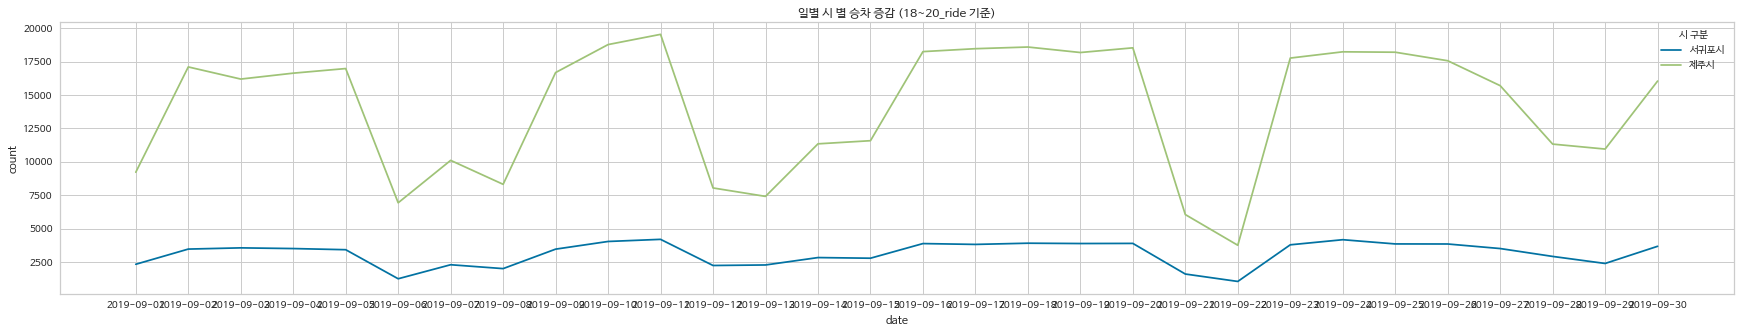

In [ ]:
plt.figure(figsize=(30,5));
plt.title('일별 시 별 승차 증감 (18~20_ride 기준)');
sns.lineplot(x='date', y='count', hue='시 구분', data=df_date_si);

#### 2) 시간대별 승차인원 비교 그래프 (2시간 간격)


In [ ]:
ride_col_list = ['68a'] + ['810a'] + ['1012a'] + ['18~20_ride']
ride_col_list

['68a', '810a', '1012a', '18~20_ride']

In [ ]:
df_date_ride = train.groupby(['date']).sum()[ride_col_list].stack().reset_index()
df_date_ride.columns = ['date', 'ride_time', 'count']
df_date_ride.head()

date   ride_time    count
0  2019-09-01         68a   7460.0
1  2019-09-01        810a  11957.0
2  2019-09-01       1012a  13505.0
3  2019-09-01  18~20_ride  11537.0
4  2019-09-02         68a  18768.0

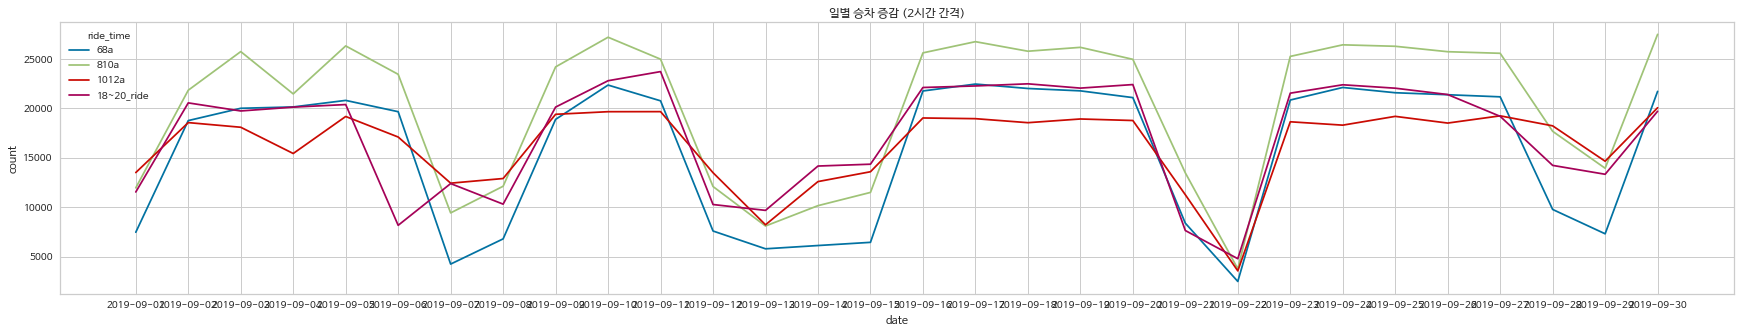

In [ ]:
plt.figure(figsize=(30,5));
plt.title('일별 승차 증감 (2시간 간격)');
sns.lineplot(x='date', y='count', hue='ride_time', data=df_date_ride);

#### 3) 18~20_ride 이상치 확인

In [ ]:
df_date_ride.head()

date   ride_time    count
0  2019-09-01         68a   7460.0
1  2019-09-01        810a  11957.0
2  2019-09-01       1012a  13505.0
3  2019-09-01  18~20_ride  11537.0
4  2019-09-02         68a  18768.0

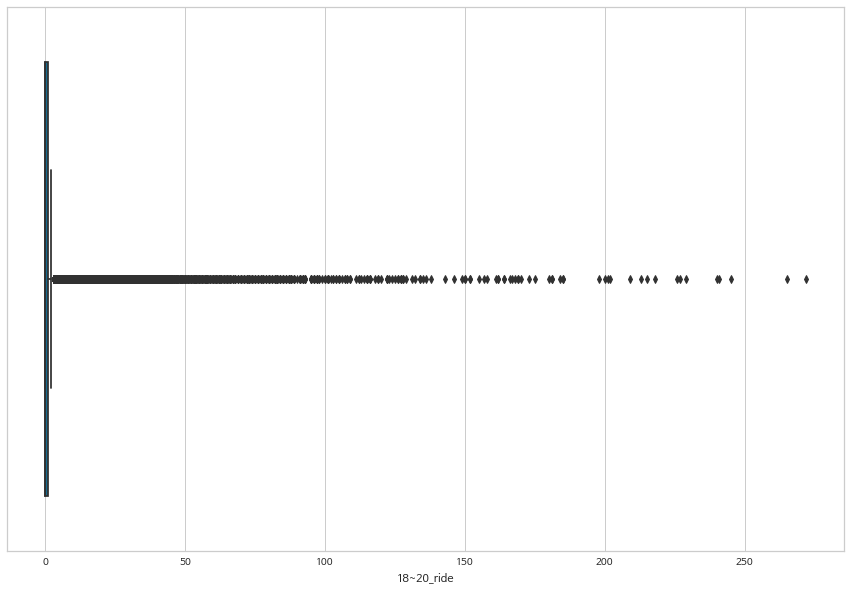

In [ ]:
plt.figure(figsize=(15,10));
sns.boxplot(x=train['18~20_ride']);
plt.xlabel('')
plt.show()

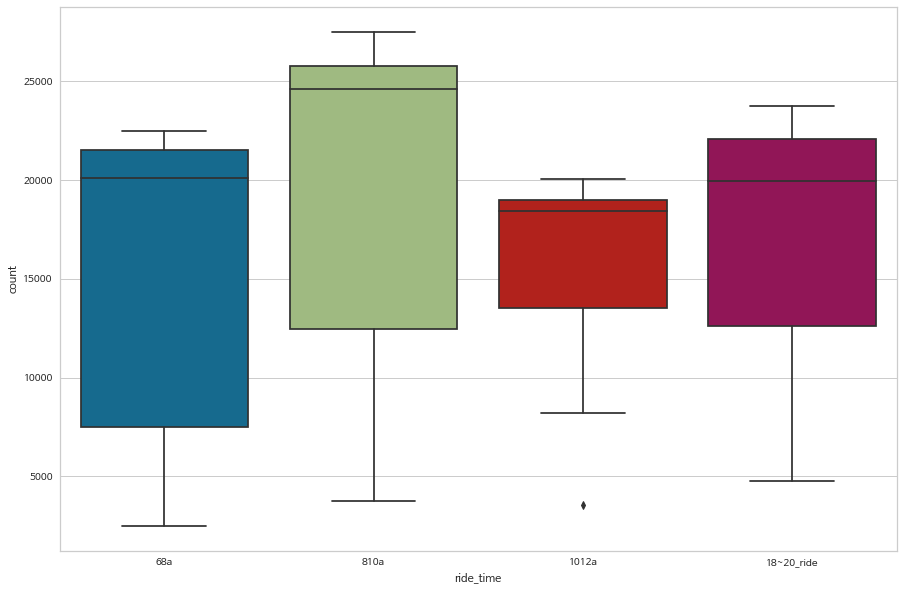

In [ ]:
plt.figure(figsize=(15,10));
sns.boxplot(x=df_date_ride['ride_time'], y=df_date_ride['count']);
plt.show()

In [ ]:
high150=train[train['18~20_ride']>=150]
high100=train[train['18~20_ride']>=100]
high150.head(10)

date  bus_route_id  in_out  station_code   station_name  \
3626    2019-09-01      23610000       0          1355  제주국제공항(신제주방면)   
15625   2019-09-02      23580000       0           201          제주대학교   
15685   2019-09-02      23610000       0           201          제주대학교   
30720   2019-09-03      23580000       0           201          제주대학교   
46048   2019-09-04      23580000       0           201          제주대학교   
46114   2019-09-04      23610000       0           201          제주대학교   
60972   2019-09-05      23580000       0           201          제주대학교   
112793  2019-09-09      23320000       0           201          제주대학교   
113729  2019-09-09      23580000       0           201          제주대학교   
113800  2019-09-09      23610000       0           201          제주대학교   

        latitude  longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  \
3626    33.50610  126.49275       1.0       5.0       7.0       10.0   
15625   33.46011  126.56166       3.0       2.0       6.0        1.0   
15685   33.46011  126.56166       2.0      10.0       9.0        5.0   
30720   33.46011  126.56166       0.0       9.0       6.0        4.0   
46048   33.46011  126.56166      30.0      17.0       7.0       28.0   
46114   33.46011  126.56166       3.0       9.0       8.0        9.0   
60972   33.46011  126.56166       2.0       4.0      12.0        2.0   
112793  33.46011  126.56166       4.0       1.0      11.0        6.0   
113729  33.46011  126.56166       2.0      11.0       8.0        6.0   
113800  33.46011  126.56166       3.0       3.0       4.0        2.0   

        10~11_ride  11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  \
3626           4.0        30.0          4.0         43.0         33.0   
15625          6.0        15.0          0.0          2.0          0.0   
15685         14.0        12.0          0.0          0.0          6.0   
30720          6.0        16.0          0.0          0.0          0.0   
46048         38.0        23.0         11.0         12.0          0.0   
46114         16.0        14.0          0.0          0.0          0.0   
60972         14.0        27.0          0.0          0.0          6.0   
112793         4.0        27.0          0.0          0.0          0.0   
113729         9.0        14.0          0.0          0.0          5.0   
113800         9.0        21.0          0.0          0.0          8.0   

        9~10_takeoff  10~11_takeoff  11~12_takeoff  18~20_ride  Rain  typhoon  \
3626            29.0           16.0           25.0       150.0     0        0   
15625            0.0           14.0            0.0       173.0     0        0   
15685            0.0            0.0            0.0       162.0     0        0   
30720            0.0            0.0            0.0       180.0     0        0   
46048            9.0           24.0            2.0       245.0     1        0   
46114            0.0            0.0            0.0       169.0     1        0   
60972            0.0            5.0            4.0       218.0     1        0   
112793           0.0            0.0            0.0       200.0     0        0   
113729           0.0            0.0            0.0       229.0     0        0   
113800           0.0            0.0            0.0       158.0     0        0   

        holiday  week  weekend  Mon  Tue  Wed  Thu  Fri  si_class  si_jeju  \
3626          0     6        1    0    0    0    0    0         1        1   
15625         0     0        0    1    0    0    0    0         1        1   
15685         0     0        0    1    0    0    0    0         1        1   
30720         0     1        0    0    1    0    0    0         1        1   
46048         0     2        0    0    0    1    0    0         1        1   
46114         0     2        0    0    0    1    0    0         1        1   
60972         0     3        0    0    0    0    1    0         1        1   
112793        0     0        0    1    0    0    0    0         1        1   
113729        0    

In [ ]:
# station_name으로 확인
print('[150명 이상]', high150['station_name'].value_counts()),
print('[100명 이상]', high100['station_name'].value_counts())

[150명 이상] 제주대학교            29
제주국제공항(구제주방면)     6
제주국제공항(신제주방면)     3
제주한라대학교           3
제주고등학교/중흥S클래스     1
Name: station_name, dtype: int64
[100명 이상] 제주대학교                 42
제주국제공항(구제주방면)         18
제주국제공항(신제주방면)         12
제주고등학교/중흥S클래스         11
제주한라대학교                5
제주시청(광양방면)             4
제주시청(아라방면)             4
큰동네                    2
회천입구                   1
제주국제공항(600번)           1
제주국제공항(대정,화순,일주서로)     1
시외버스출발지(가상정류소)         1
산천단한국폴리텍대학             1
Name: station_name, dtype: int64


In [ ]:
# bus_route_id 기준으로 확인
print('[150명 이상]', high150['bus_route_id'].value_counts()),
print('[100명 이상]', high100['bus_route_id'].value_counts())

[150명 이상] 23580000    17
23610000    14
23620000     9
23320000     1
23570000     1
Name: bus_route_id, dtype: int64
[100명 이상] 23610000    30
23580000    27
23620000    23
23570000     7
22520000     5
23320000     2
29790000     2
29990000     1
23240000     1
23500000     1
4270000      1
21410000     1
22530000     1
23460000     1
Name: bus_route_id, dtype: int64


In [ ]:
# date으로 확인
high150['date'].value_counts()

2019-09-16    4
2019-09-26    3
2019-09-09    3
2019-09-18    3
2019-09-19    3
2019-09-23    2
2019-09-29    2
2019-09-04    2
2019-09-10    2
2019-09-11    2
2019-09-25    2
2019-09-15    2
2019-09-02    2
2019-09-17    2
2019-09-24    2
2019-09-01    1
2019-09-20    1
2019-09-14    1
2019-09-05    1
2019-09-03    1
2019-09-30    1
Name: date, dtype: int64

In [ ]:
# date으로 확인
high100['date'].value_counts()

2019-09-24    7
2019-09-16    6
2019-09-09    6
2019-09-18    6
2019-09-25    6
2019-09-11    6
2019-09-04    6
2019-09-26    5
2019-09-23    5
2019-09-02    5
2019-09-20    5
2019-09-05    4
2019-09-15    4
2019-09-17    4
2019-09-03    4
2019-09-19    4
2019-09-27    3
2019-09-01    3
2019-09-14    3
2019-09-10    3
2019-09-30    3
2019-09-29    2
2019-09-13    1
2019-09-06    1
2019-09-28    1
Name: date, dtype: int64

In [ ]:
bus23610000=train[train['bus_route_id']==23610000]
bus23610000['station_name'].unique()

array(['남국사', '제주대학교병원', '인다마을', '아라주공아파트', '아라동주민센터', '제원아파트', '은남동',
       '도호동', '제주대학교', '제대아파트', '제대마을', '보성시장', '중앙로(현대약국)', '시민회관',
       '화물청사입구', '용문마을회관', '용문마을', '용문사거리', '용담1동주민센터', '연동주민센터',
       '제주도청신제주로터리', '서문시장', '관덕정', '한라병원', '월랑마을남녕고등학교', '삼무공원사거리',
       '제주한라대학교', '시티주유소', '중흥S클래스아파트', '으뜸마을', '제주제일고등학교', '원노형', '다호마을',
       '연동입구', '제주대학교입구', '제주국제공항(신제주방면)', '제주한라대학교(종점)', '제주시청(광양방면)',
       '고산동산(광양방면)', '제주지방법원(광양방면)', '제주중앙여자고등학교(광양방면)',
       '제주여자중고등학교(광양방면)', '남국원(광양방면)', '중앙로(국민은행)', '노형오거리', '삼성초등학교',
       '제주중학교/제주향교', '남녕고등학교', '남국원(아라방면)', '제주시청(아라방면)', '고산동산(아라방면)',
       '제주지방법원(아라방면)', '제주중앙여자고등학교(아라방면)', '제주여자중고등학교(아라방면)', '웃인다마을',
       '정존마을', '월성마을', '노형초등학교', '광양'], dtype=object)

In [ ]:
bus23580000 =train[train['bus_route_id']==23580000]
bus23580000['station_name'].unique()

array(['남국사', '웃인다마을', '제주대학교병원', '인다마을', '아라주공아파트', '아라동주민센터', '용천마을',
       '제주버스터미널', '한국병원', '광양사거리', '탐라장애인종합복지관', '홍랑로입구', '동산교', '명신마을',
       '제원아파트', '은남동', '도호동', '제주대학교', '제대아파트', '제주대학교입구', '연동주민센터',
       '제주도청신제주로터리', '한라병원', '월랑마을남녕고등학교', '삼무공원사거리', '으뜸마을', '탐라도서관',
       '제주고등학교/중흥S클래스', '제주제일고등학교', '오라오거리', '원노형', '연동입구', '제주시청(광양방면)',
       '고산동산(광양방면)', '제주지방법원(광양방면)', '제주중앙여자고등학교(광양방면)',
       '제주여자중고등학교(광양방면)', '남국원(광양방면)', '케이티앤지', '남서광마을', '제대마을',
       '한라중학교/부영아파트', '대림2차아파트', '롯데마트', '제주시청(아라방면)', '남서광마을입구',
       '남녕고등학교', '제주중앙여자고등학교(아라방면)', '연동대림1차아파트', '노형오거리', '부영아파트',
       '제주지방법원(아라방면)', '아라초등학교', '월구마을'], dtype=object)

In [ ]:
bus23620000 =train[train['bus_route_id']==23620000]
bus23620000['station_name'].unique()

array(['남국사', '죽성마을입구', '제주대학교병원', '인다마을', '아라주공아파트', '아라초등학교', '제원아파트',
       '은남동', '도호동', '제주대학교', '제대아파트', '제대마을', '제주대학교입구', '삼성초등학교', '광양',
       '중앙로(국민은행)', '시민회관', '용문마을회관', '용문마을', '용문사거리', '용담1동주민센터',
       '제주중학교/제주향교', '연동주민센터', '제주도청신제주로터리', '서문시장', '관덕정', '한라병원',
       '노형오거리', '남녕고등학교', '삼무공원사거리', '정존마을', '노형초등학교', '제주한라대학교', '월성마을',
       '제주국제공항(구제주방면)', '제주시청(아라방면)', '고산동산(아라방면)', '제주지방법원(아라방면)',
       '제주중앙여자고등학교(아라방면)', '제주여자중고등학교(아라방면)', '남국원(아라방면)',
       '제주국제공항(신제주방면)', '보성시장', '중앙로(현대약국)', '화물청사입구', '제주시청(광양방면)',
       '제주지방법원(광양방면)', '고산동산(광양방면)', '제주중앙여자고등학교(광양방면)',
       '제주여자중고등학교(광양방면)'], dtype=object)

In [ ]:
count0=train[train['18~20_ride']==0]
count0.groupby(['date', 'bus_route_id']).sum().reset_index()

date  bus_route_id  in_out  station_code     latitude  \
0      2019-09-01       4270000       7         30550   465.968840   
1      2019-09-01       4280000       9         32016   499.387030   
2      2019-09-01       8170000       1         10582   166.749910   
3      2019-09-01       8180000       0         13277   233.508800   
4      2019-09-01      17010000       0       6000027    33.486549   
...           ...           ...     ...           ...          ...   
15616  2019-09-30      32730000       0       6134411   531.954160   
15617  2019-09-30      32740000       0         36865  1639.023890   
15618  2019-09-30      32760000       0         36813   635.128310   
15619  2019-09-30      32810000       0       6118697    99.909620   
15620  2019-09-30      32820000       0       6126105   300.514680   

         longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  10~11_ride  \
0      1770.455040       2.0       2.0       6.0        7.0         6.0   
1      1897.085810       7.0      16.0      24.0       16.0        15.0   
2       632.512290       1.0       2.0       0.0        1.0         1.0   
3       885.450370       3.0      13.0       5.0        6.0         0.0   
4       126.499152       0.0       0.0       0.0        0.0         2.0   
...            ...       ...       ...       ...        ...         ...   
15616  2022.321880      12.0       0.0       0.0        0.0         0.0   
15617  6191.393200       0.0      32.0      21.0        4.0         0.0   
15618  2405.397520      11.0       8.0       0.0        0.0         0.0   
15619   379.106420       1.0       1.0       0.0        0.0         0.0   
15620  1137.117590      10.0       0.0       0.0        0.0         0.0   

       11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  \
0            12.0          0.0          2.0          3.0           4.0   
1            11.0          1.0          4.0          2.0           3.0   
2             0.0          0.0          1.0          1.0           0.0   
3             3.0          0.0          3.0         13.0           8.0   
4             3.0          0.0          0.0          0.0           0.0   
...           ...          ...          ...          ...           ...   
15616         0.0          9.0          2.0          0.0           0.0   
15617         0.0          0.0         10.0         15.0          15.0   
15618         0.0          1.0         16.0          0.0           0.0   
15619         0.0          1.0          1.0          0.0           0.0   
15620         0.0          2.0          2.0          4.0           0.0   

       10~11_takeoff  11~12_takeoff  18~20_ride  Rain  typhoon  holiday  week  \
0               16.0            6.0         0.0     0        0        0    84   
1                1.0            4.0         0.0     0        0        0    90   
2                3.0            1.0         0.0     0        0        0    30   
3               11.0            0.0         0.0     0        0        0    42   
4                0.0            0.0         0.0     0        0        0     6   
...              ...            ...         ...   ...      ...      ...   ...   
15616            0.0            0.0         0.0     0        0        0     0   
15617            0.0            0.0         0.0     0        0        0     0   
15618            0.0            0.0         0.0     0        0        0     0   
15619            0.0            0.0         0.0     0        0        0     0   
15620            0.0            0.0         0.0     0        0        0     0   

       weekend  Mon  Tue  Wed  Thu  Fri  si_class  si_jeju  si_seogwipo  \
0           14    0    0    0    0    0         2        2           12   
1           15    0    0    0    0    0         3        3           12   
2            5    0    0    0    0    0         2        2            3   
3            7    0    0    0    0    0         3        3            4   
4            1    0    0    0    0

### (5) Modeling

#### 1) 필요한 data만 sorting

In [ ]:
train=pd.read_csv("/content/drive/MyDrive/Project/팀 프로젝트/2_jeju_bus/data/train_final.csv", index_col = 0)
test=pd.read_csv("/content/drive/MyDrive/Project/팀 프로젝트/2_jeju_bus/data/test_final.csv", index_col = 0)

In [ ]:
# 테이블에서 필요없는 컬럼들 제거
train_x = train.drop(['date', 'station_name', 'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff','7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'week'], axis = 1)
test_x = test.drop(['date', 'station_name', 'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff','7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'week'], axis = 1)
train_x.head()

bus_route_id  in_out  station_code  18~20_ride  Rain  typhoon  holiday  \
0       4270000       1           344         0.0     0        0        0   
1       4270000       1           357         5.0     0        0        0   
2       4270000       1           432         2.0     0        0        0   
3       4270000       0          1579        53.0     0        0        0   
4       4270000       0          1646         0.0     0        0        0   

   weekend  Mon  Tue  Wed  Thu  Fri  si_jeju  si_seogwipo   dis_jeju  \
0        1    0    0    0    0    0        1            0   4.286659   
1        1    0    0    0    0    0        1            0   4.966848   
2        1    0    0    0    0    0        1            0   6.330746   
3        1    0    0    0    0    0        1            0   3.575272   
4        1    0    0    0    0    0        0            1  30.652098   

   dis_gosan  dis_seongsan     dis_po  dist_name   68a  810a  1012a  
0  37.692766     37.713630  27.841879          0   1.0   7.0    8.0  
1  37.008492     38.465822  27.996179          0   5.0   6.0   11.0  
2  35.642126     39.259820  27.496551          0   2.0   2.0    0.0  
3  38.643401     38.386802  29.579404          0  17.0  32.0   30.0  
4  23.648361     45.899140  14.269792          3   0.0   0.0    0.0

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   bus_route_id  415423 non-null  int64  
 1   in_out        415423 non-null  int64  
 2   station_code  415423 non-null  int64  
 3   18~20_ride    415423 non-null  float64
 4   Rain          415423 non-null  int64  
 5   typhoon       415423 non-null  int64  
 6   holiday       415423 non-null  int64  
 7   weekend       415423 non-null  int64  
 8   Mon           415423 non-null  int64  
 9   Tue           415423 non-null  int64  
 10  Wed           415423 non-null  int64  
 11  Thu           415423 non-null  int64  
 12  Fri           415423 non-null  int64  
 13  si_jeju       415423 non-null  int64  
 14  si_seogwipo   415423 non-null  int64  
 15  dis_jeju      415423 non-null  float64
 16  dis_gosan     415423 non-null  float64
 17  dis_seongsan  415423 non-null  float64
 18  dis_

In [ ]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228170 entries, 0 to 228169
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   bus_route_id  228170 non-null  int64  
 1   in_out        228170 non-null  int64  
 2   station_code  228170 non-null  int64  
 3   Rain          228170 non-null  int64  
 4   typhoon       228170 non-null  int64  
 5   holiday       228170 non-null  int64  
 6   weekend       228170 non-null  int64  
 7   Mon           228170 non-null  int64  
 8   Tue           228170 non-null  int64  
 9   Wed           228170 non-null  int64  
 10  Thu           228170 non-null  int64  
 11  Fri           228170 non-null  int64  
 12  si_jeju       228170 non-null  int64  
 13  si_seogwipo   228170 non-null  int64  
 14  dis_jeju      228170 non-null  float64
 15  dis_gosan     228170 non-null  float64
 16  dis_seongsan  228170 non-null  float64
 17  dis_po        228170 non-null  float64
 18  dist

#### 2) pycaret 사용

In [ ]:
# reproducibility 씨드의 배열은 랜덤하지 않게 유지하기 위한 장치
def seed_all(seed_num):
    rn.seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)
    np.random.seed(seed_num)

seed_all(42)

In [ ]:
seed_num = 42
py_reg = setup(train_x, target = '18~20_ride', fold_shuffle = True, session_id = seed_num, normalize = True, silent = True, remove_outliers = True)

Description             Value
0                               session_id                42
1                                   Target        18~20_ride
2                            Original Data      (415423, 23)
3                           Missing Values             False
4                         Numeric Features                 9
5                     Categorical Features                13
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set      (276256, 24)
10                    Transformed Test Set      (124627, 24)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number                10
15                                CPU Jobs                -1
16                                 Use GPU             False
17                          Log Experiment             False
18                         Experiment Name  reg-default-name
19                                     USI              1089
20                         Imputation Type            simple
21          Iterative Imputation Iteration              None
22                         Numeric Imputer              mean
23      Iterative Imputation Numeric Model              None
24                     Categorical Imputer          constant
25  Iterative Imputation Categorical Model              None
26           Unknown Categoricals Handling    least_frequent
27                               Normalize              True
28                        Normalize Method            zscore
29                          Transformation             False
30                   Transformation Method              None
31                                     PCA             False
32                              PCA Method              None
33                          PCA Components              None
34                     Ignore Low Variance             False
35                     Combine Rare Levels             False
36                    Rare Level Threshold              None
37                         Numeric Binning             False
38                         Remove Outliers              True
39                      Outliers Threshold              0.05
40                Remove Multicollinearity             False
41             Multicollinearity Threshold              None
42             Remove Perfect Collinearity              True
43                              Clustering             False
44                    Clustering Iteration              None
45                     Polynomial Features             False
46                       Polynomial Degree              None
47                    Trignometry Features             False
48                    Polynomial Threshold              None
49                          Group Features             False
50                       Feature Selection             False
51                Feature Selection Method           classic
52            Features Selection Threshold              None
53                     Feature Interaction             False
54                           Feature Ratio             False
55                   Interaction Threshold              None
56                        Transform Target             False
57                 Transform Target Method           box-cox

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='18~20_ride', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_stra...
                 Outlier(contamination=0.05, methods=['pca'], random_state=42,
                         target='18~20_ride')),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummify(tar

In [ ]:
best_models = compare_models(n_select=3, sort='RMSE')

Model     MAE      MSE    RMSE      R2  \
catboost               CatBoost Regressor  0.8868   4.3857  2.0932  0.5582   
rf                Random Forest Regressor  0.8572   4.7013  2.1667  0.5264   
lightgbm  Light Gradient Boosting Machine  0.9296   4.7922  2.1881  0.5171   
et                  Extra Trees Regressor  0.9533   5.6022  2.3657  0.4354   
gbr           Gradient Boosting Regressor  1.0112   6.0915  2.4663  0.3869   
lr                      Linear Regression  1.1262   7.2817  2.6964  0.2673   
lar                Least Angle Regression  1.1262   7.2817  2.6964  0.2673   
br                         Bayesian Ridge  1.1259   7.2818  2.6964  0.2673   
ridge                    Ridge Regression  1.1244   7.2846  2.6970  0.2670   
omp           Orthogonal Matching Pursuit  1.0998   7.4481  2.7271  0.2505   
knn                 K Neighbors Regressor  1.0566   7.6774  2.7693  0.2268   
huber                     Huber Regressor  0.9436   8.3565  2.8888  0.1590   
en                            Elastic Net  1.3536   9.0524  3.0070  0.0886   
dt                Decision Tree Regressor  1.0483   9.1872  3.0299  0.0727   
lasso                    Lasso Regression  1.4465   9.9298  3.1497 -0.0000   
llar         Lasso Least Angle Regression  1.4465   9.9298  3.1497 -0.0000   
dummy                     Dummy Regressor  1.4465   9.9298  3.1497 -0.0000   
par          Passive Aggressive Regressor  2.2134  12.7548  3.5115 -0.2907   
ada                    AdaBoost Regressor  3.6212  30.0003  5.0282 -1.9897   

           RMSLE    MAPE  TT (Sec)  
catboost  0.4923  0.6470    30.025  
rf        0.4945  0.6992    47.013  
lightgbm  0.5104  0.6619     0.676  
et        0.5444  0.7758    32.158  
gbr       0.5471  0.6953    15.462  
lr        0.5930  0.7544     0.401  
lar       0.5930  0.7544     0.044  
br        0.5928  0.7543     0.174  
ridge     0.5919  0.7538     0.046  
omp       0.5932  0.7538     0.048  
knn       0.5867  0.8481    44.945  
huber     0.5384  0.7232     1.281  
en        0.6811  0.4550     0.052  
dt        0.6122  1.0132     0.873  
lasso     0.7411  0.4228     0.048  
llar      0.7411  0.4228     0.047  
dummy     0.7411  0.4228     0.164  
par       0.9379  1.3054     0.198  
ada       1.2390  2.1919     4.148

INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 2
INFO:logs:[<catboost.core.CatBoostRegressor object at 0x7fa8ee3b3650>, RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=

In [ ]:
best_models

 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False),
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)]

#### 3) 상위 3 모델 확인

In [ ]:
# 상위 3개 모델 생성
catboost = create_model('catboost', verbose = False)
rf = create_model('rf', verbose = False)
lightgbm = create_model('lightgbm', verbose = False)

INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=catboost, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=False, system=True, metrics=None, experiment_custom_tags=None, add_to_model_list=True, probability_threshold=None, display=None, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:CatBoost Regressor Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with KFold(n_splits=10, random_state=42, shuffle=True), n_jobs=-1
INFO:logs:Calculating mean and std
INFO:logs:Creating metrics dataframe
INFO:logs:Finalizing model
INFO:logs:Uploading results into container
INFO:logs:Uploading model into container now
INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:dis

In [ ]:
blend_models = blend_models(estimator_list = [catboost, rf, lightgbm])

MAE     MSE    RMSE      R2   RMSLE    MAPE
Fold                                                
0     0.8752  4.1182  2.0293  0.5573  0.4794  0.6509
1     0.8601  4.3860  2.0943  0.5468  0.4773  0.6415
2     0.8586  4.3177  2.0779  0.5687  0.4782  0.6319
3     0.8699  4.6914  2.1660  0.5569  0.4828  0.6280
4     0.8592  4.2234  2.0551  0.5586  0.4783  0.6388
5     0.8499  4.4008  2.0978  0.5779  0.4756  0.6178
6     0.8803  5.0628  2.2501  0.5365  0.4818  0.6379
7     0.8703  4.1580  2.0391  0.5806  0.4838  0.6205
8     0.8614  3.9615  1.9904  0.5466  0.4825  0.6377
9     0.8660  4.1851  2.0458  0.5876  0.4787  0.6208
Mean  0.8651  4.3505  2.0846  0.5617  0.4798  0.6326
Std   0.0085  0.3024  0.0712  0.0157  0.0026  0.0102

INFO:logs:create_model_container: 23
INFO:logs:master_model_container: 23
INFO:logs:display_container: 6
INFO:logs:VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7fa9091f2890>),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
             

In [ ]:
final_model = finalize_model(blend_models)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7fa9091f2890>),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   mi

In [ ]:
final_model

VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7fa9116c14d0>),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_w

In [ ]:
prediction = predict_model(final_model, data = test_x)
prediction

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7fa9116c14d0>),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_

bus_route_id  in_out  station_code  Rain  typhoon  holiday  weekend  \
0            4270000       1           344     0        1        0        0   
1            4270000       1           357     0        1        0        0   
2            4270000       1           432     0        1        0        0   
3            4270000       0          1579     0        1        0        0   
4            4270000       0          1636     0        1        0        0   
...              ...     ...           ...   ...      ...      ...      ...   
228165      32820000       0           786     0        0        0        0   
228166      32820000       0          1080     0        0        0        0   
228167      32820000       0          1129     0        0        0        0   
228168      32820000       0          1564     0        0        0        0   
228169      32820000       0       6115100     0        0        0        0   

        Mon  Tue  Wed  ...  si_seogwipo   dis_jeju  dis_gosan  dis_seongsan  \
0         0    1    0  ...            0   4.286659  37.692766     37.713630   
1         0    1    0  ...            0   4.966848  37.008492     38.465822   
2         0    1    0  ...            0   6.330746  35.642126     39.259820   
3         0    1    0  ...            0   3.575272  38.643401     38.386802   
4         0    1    0  ...            1  31.460686  23.594010     46.355301   
...     ...  ...  ...  ...          ...        ...        ...           ...   
228165    0    0    1  ...            0  40.193817   1.810388     65.835199   
228166    0    0    1  ...            0  19.020368  24.608845     51.446906   
228167    0    0    1  ...            0  27.117280  16.319339     57.465292   
228168    0    0    1  ...            0   2.134693  39.904297     36.202951   
228169    0    0    1  ...            1  29.502808  32.543755     37.889853   

           dis_po  dist_name   68a  810a  1012a      Label  
0       27.841879          0   8.0   9.0   10.0   7.809430  
1       27.996179          0   7.0   7.0   19.0   9.184055  
2       27.496551          0   6.0   4.0    3.0   4.063260  
3       29.579404          0  12.0  26.0   46.0  46.873706  
4       14.445605          3   0.0   0.0    0.0   0.625324  
...           ...        ...   ...   ...    ...        ...  
228165  36.362254          1   0.0   0.0    0.0  -0.004355  
228166  32.217732          0   0.0   0.0    0.0   0.034693  
228167  33.738981          1   3.0   0.0    0.0   0.115322  
228168  28.484278          0   3.0   0.0    0.0   0.497858  
228169   5.348404          3   0.0   0.0    0.0   0.045471  

[228170 rows x 23 columns]

#### 4) final Vs 상위 3개 모델

##### final 모델

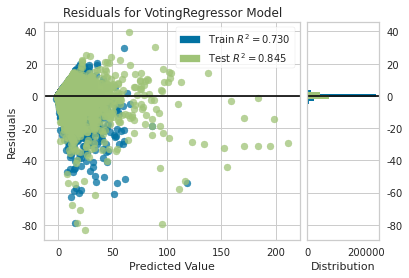

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(final_model, plot = 'residuals')

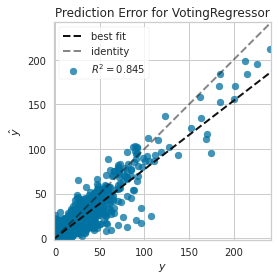

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(final_model, plot = 'error')

In [ ]:
evaluate_model(final_model)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7fa9116c14d0>),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   mi

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### catboost

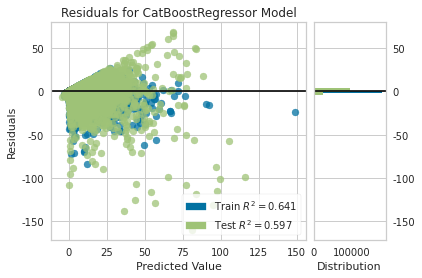

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(catboost, plot = 'residuals')

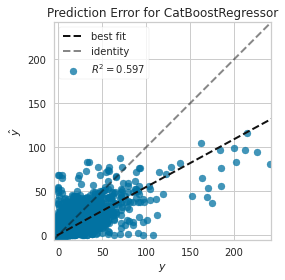

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(catboost, plot = 'error')

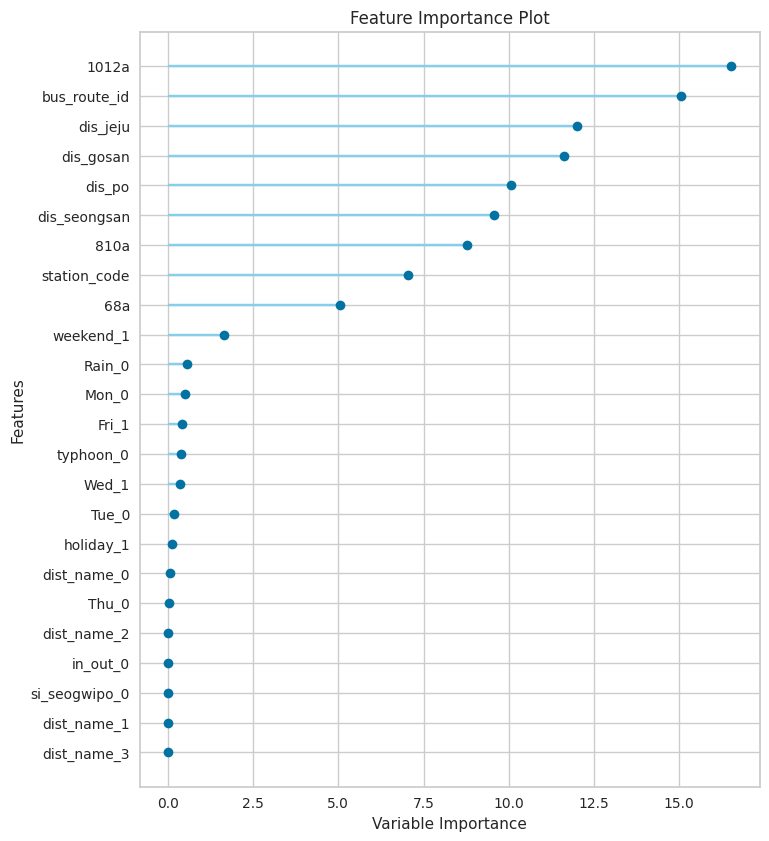

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(catboost, plot = 'feature_all')

##### rf

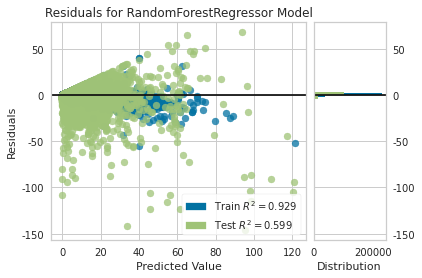

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(rf, plot = 'residuals')

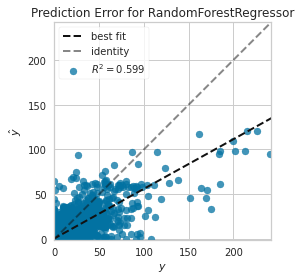

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(rf, plot = 'error')

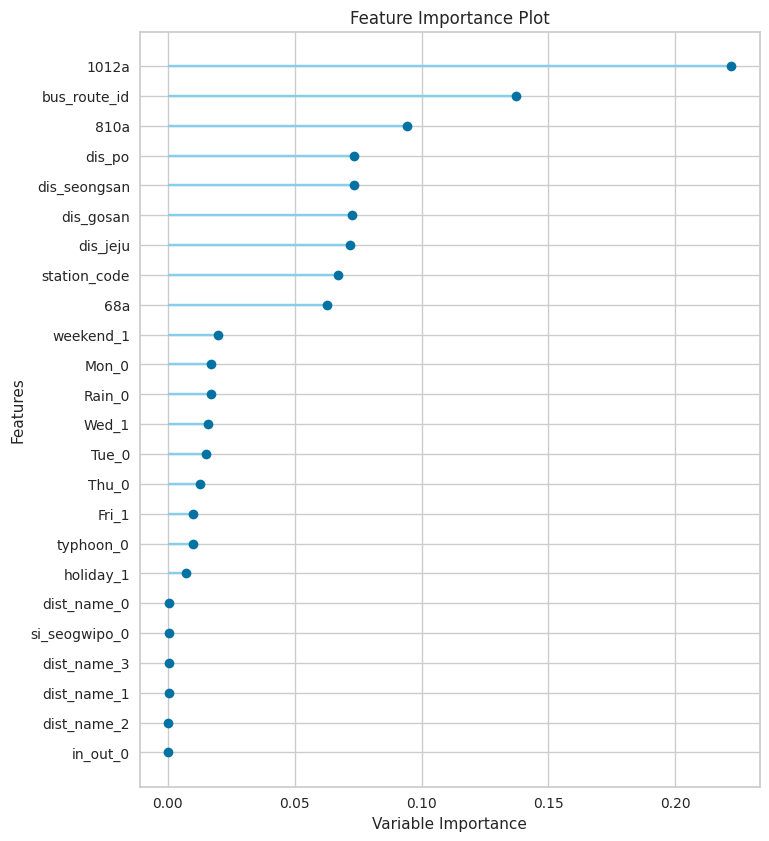

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(rf, plot = 'feature_all')

##### lightgbm

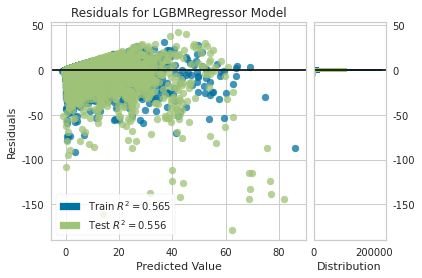

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(lightgbm, plot = 'residuals')

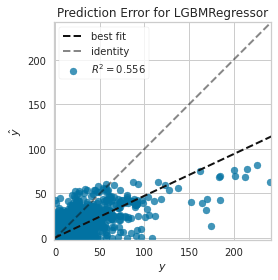

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(lightgbm, plot = 'error')

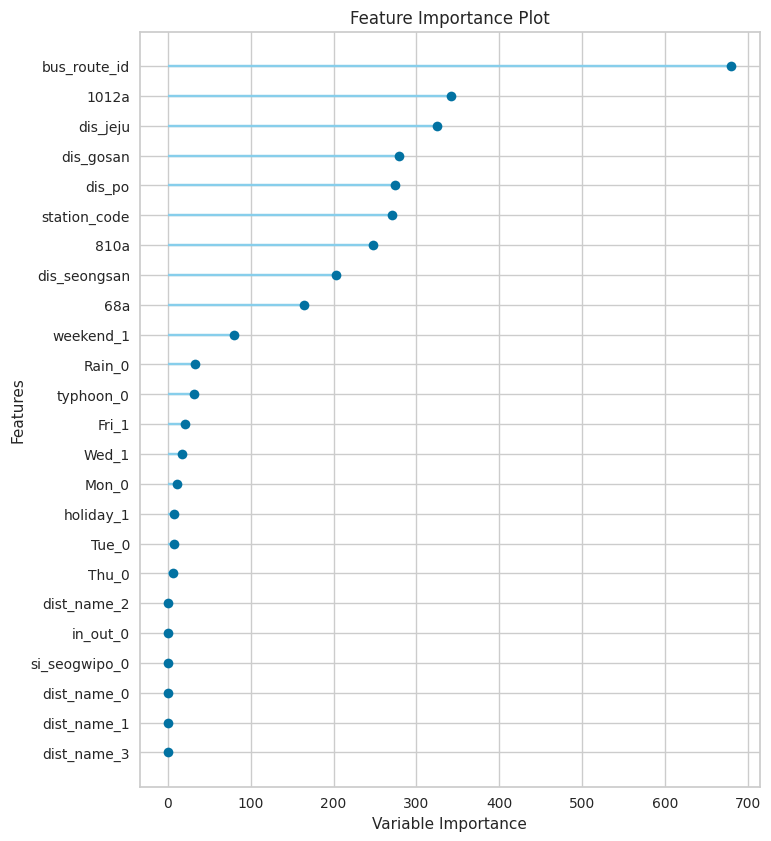

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(lightgbm, plot = 'feature_all')